In [1]:
import numpy as np
import yaml
import random
import matplotlib.pyplot as plt

In [2]:
def transform_already_played_matches(ranking, already_played):
    player_to_rank = {}

    for rank, player in enumerate(ranking):
        player_to_rank[player] = rank
    
    already_played_matches = []

    for m in already_played:
        p1 = player_to_rank[int(m.split(';')[0])]
        p2 = player_to_rank[int(m.split(';')[1])]
        
        already_played_matches.append((p1, p2))
    
    return already_played_matches

In [3]:
def matchmaking_matrix_to_matches(ranking, matchmaking_matrix):
    rank_to_player = {}
    
    for rank, player in enumerate(ranking):
        rank_to_player[rank] = player
        
    matches = []
    
    for p1 in range(matchmaking_matrix.shape[0]):
        for p2 in range(matchmaking_matrix.shape[0]):
            if matchmaking_matrix[p1, p2] == 1:
                matches.append((rank_to_player[p1], rank_to_player[p2]))
    
    return matches

In [4]:
def create_already_played_matrix(player_count, already_played_matches):
    already_played_matrix = np.zeros((player_count, player_count))
    
    for m in already_played_matches:
        already_played_matrix[m[0], m[1]] += 1
        already_played_matrix[m[1], m[0]] += 1
    
    return already_played_matrix

In [5]:
def read_matchmaking_input(path):
    with open(path) as file:
        input_info = yaml.load(file, Loader=yaml.FullLoader)
    
    return input_info

In [6]:
def create_ranking_distance_matrix(player_count):
    ranking_distance_matrix = np.zeros((player_count, player_count), dtype=int)

    for i in range(player_count):
        for y in range(player_count):
            ranking_distance_matrix[i, y] = abs(i-y)
            ranking_distance_matrix[y, i] = abs(i-y)
            
    return ranking_distance_matrix

In [7]:
def calculate_already_played_score(matchmaking_matrix, already_played_matrix):
    return int((matchmaking_matrix * already_played_matrix).sum())

In [8]:
def calculate_ranking_distance_score(matchmaking_matrix, ranking_distance_matrix):
    return int((matchmaking_matrix * ranking_distance_matrix).sum())

In [9]:
def get_inital_matchmaking_matrix(path):
    initial_matrix = np.load(path)

    for p1 in range(initial_matrix.shape[0]):
        for p2 in range(initial_matrix.shape[0]):
            if p1 > p2:
                initial_matrix[p1, p2] = 0
                
    return initial_matrix

In [10]:
def create_groups(player_count, group_size):
    ranking = list(range(player_count))
    c_group = 0
    c_group_size = 0
    groups = [[]]

    for player in ranking:
        c_group_size +=1
        groups[c_group].append(player)

        if c_group_size == group_size:
            c_group_size = 0
            c_group += 1

            if player < player_count-1:
                groups.append([])
    
    return groups

In [11]:
def initialize_matchmaking_matrix(groups):
    player_count = np.sum([len(g) for g in groups])
    
    matchmaking_matrix = np.zeros((player_count, player_count), dtype=int)
    
    for g in groups:
        for p1 in g:
            for p2 in g:                
                if p1 < p2:
                    matchmaking_matrix[p1, p2] = 1
    
    return matchmaking_matrix

In [12]:
def get_non_group_matches(group_matchmaking_matrix, matchmaking_matrix):
    non_group_matches = (group_matchmaking_matrix != 1) & (matchmaking_matrix == 1)
    return np.argwhere(non_group_matches)

In [13]:
def swap_if_first_is_bigger(arr):
    arr_0 = arr[0]
    arr_1 = arr[1]
    
    if arr_0 > arr_1:
        tmp = arr_0
        arr_0 = arr_1
        arr_1 = tmp
    
    return (arr_0, arr_1)

In [14]:
def pick_two_random_non_overlapping_matches(matches, matchmaking_matrix):   
    while True:
        if len(matches) == 0:
            print(matches, matchmaking_matrix)
        
        random_pick = random.choice(matches)

        remaining_matches_idx = (matches[:,0] != random_pick[0]) & (matches[:,1] != random_pick[0]) & (matches[:,0] != random_pick[1]) & (matches[:,1] != random_pick[1])
        remaining_matches = matches[remaining_matches_idx]

        remaining_second_picks = []

        for m in remaining_matches:
            m1_p1, m1_p2 = swap_if_first_is_bigger(random_pick)
            m2_p1, m2_p2 = swap_if_first_is_bigger(m)
            
            new_m1_p1, new_m1_p2 = swap_if_first_is_bigger([m1_p1, m2_p1])
            new_m2_p1, new_m2_p2 = swap_if_first_is_bigger([m1_p2, m2_p2])

            if (matchmaking_matrix[new_m1_p1, new_m1_p2] == 0) & (matchmaking_matrix[new_m2_p1, new_m2_p2] == 0):                
                remaining_second_picks.append(([m1_p1, m1_p2], [m2_p1, m2_p2], [new_m1_p1, new_m1_p2], [new_m2_p1, new_m2_p2]))
            
            new_m1_p1, new_m1_p2 = swap_if_first_is_bigger([m1_p1, m2_p2])
            new_m2_p1, new_m2_p2 = swap_if_first_is_bigger([m1_p2, m2_p1])
            
            if (matchmaking_matrix[new_m1_p1, new_m1_p2] == 0) & (matchmaking_matrix[new_m2_p1, new_m2_p2] == 0):                
                remaining_second_picks.append(([m1_p1, m1_p2], [m2_p1, m2_p2], [new_m1_p1, new_m1_p2], [new_m2_p1, new_m2_p2]))

        if len(remaining_second_picks) > 0:
            pick = random.choice(remaining_second_picks)

            return pick

In [15]:
def randomly_mutate_matchmaking(matchmaking_matrix, group_matchmaking_matrix):
    matchmaking_matrix_copy = np.copy(matchmaking_matrix)
    non_group_matches = get_non_group_matches(group_matchmaking_matrix, matchmaking_matrix)
    
    m1, m2, new_m1, new_m2 = pick_two_random_non_overlapping_matches(non_group_matches, matchmaking_matrix)
    
    matchmaking_matrix_copy[m1[0], m1[1]] = 0
    matchmaking_matrix_copy[m2[0], m2[1]] = 0
    
    matchmaking_matrix_copy[new_m1[0], new_m1[1]] = 1
    matchmaking_matrix_copy[new_m2[0], new_m2[1]] = 1
    
    return matchmaking_matrix_copy

In [16]:
def measure_generation(generation, already_played_matrix):
    metrics = []
    
    for mm in generation:
        metrics.append(calculate_already_played_score(mm, already_played_matrix))
        
    return metrics

In [17]:
def measure_generation_ranking_distance(generation, ranking_distance_matrix):
    metrics = []
    
    for mm in generation:
        metrics.append(calculate_ranking_distance_score(mm, ranking_distance_matrix))
        
    return metrics

In [18]:
def get_top_n_matchmakings(generation, already_played_matrix, n):    
    measured_mm = []
    
    for mm in generation:
        measured_mm.append((calculate_already_played_score(mm, already_played_matrix), mm))
    
    measured_mm = sorted(measured_mm, key=lambda tup:tup[0])
    
    return [mm[1] for mm in measured_mm[:n]]

In [19]:
def check_if_already_exists(best_matchmakings, new_mm):
    for mm in best_matchmakings:
        comparison = mm == new_mm
        if comparison.all():
            return True
    
    return False

# Start

In [40]:
input_info = read_matchmaking_input(r'matchmaking_input2.yml')

In [41]:
player_count = len(input_info['ranking'])
group_size = input_info['group_size']

In [42]:
ranking_distance_matrix = create_ranking_distance_matrix(player_count)

In [43]:
already_played_matches = transform_already_played_matches(input_info['ranking'], input_info['already_played'])

In [44]:
already_played_matrix = create_already_played_matrix(player_count, already_played_matches)

In [45]:
groups = create_groups(player_count, group_size)

In [46]:
group_matchmaking_matrix = initialize_matchmaking_matrix(groups)

In [47]:
print(calculate_already_played_score(group_matchmaking_matrix, already_played_matrix))

8


In [48]:
#initial_matrix_1 = get_inital_matchmaking_matrix(r'matchmaking_12\8551642488702733955927625738021899162112150.npy')
#initial_matrix_2 = get_inital_matchmaking_matrix(r'matchmaking_12\9085031122769073757818832259676047196443670.npy')
#initial_matrix_3 = get_inital_matchmaking_matrix(r'matchmaking_12\9411722121750364303728292036614807439626510.npy')
#initial_matrix_4 = get_inital_matchmaking_matrix(r'matchmaking_12\10457219770216483406265979385486313366639630.npy')
#initial_matrix_5 = get_inital_matchmaking_matrix(r'matchmaking_12\10108437016143459162592009031721746985799830.npy')

initial_matrix_1 = get_inital_matchmaking_matrix(r'matchmaking_9\1079750504534497710381670.npy')
initial_matrix_2 = get_inital_matchmaking_matrix(r'matchmaking_9\1098603076977708845836902.npy')
initial_matrix_3 = get_inital_matchmaking_matrix(r'matchmaking_9\957181453519009891621526.npy')
initial_matrix_4 = get_inital_matchmaking_matrix(r'matchmaking_9\994969174314668763580958.npy')
initial_matrix_5 = get_inital_matchmaking_matrix(r'matchmaking_9\1004146641129666916407974.npy')

initial_generation = [initial_matrix_1, initial_matrix_2, initial_matrix_3, initial_matrix_4, initial_matrix_5]

new_mm = []

for mm in initial_generation:
    new_mm.append(randomly_mutate_matchmaking(mm, group_matchmaking_matrix))

initial_generation += new_mm

In [49]:
mean_scores = []
min_scores = []
min_ranking_distances = []
best_matchmakings_length = []
best_matchmakings = []

scores = measure_generation(initial_generation, already_played_matrix)
min_score = np.min(scores)

for idx, score in enumerate(scores):
    if score == min_score:
        if not check_if_already_exists(best_matchmakings, initial_generation[idx]):
            best_matchmakings.append(initial_generation[idx])
            
ranking_distance_scores = measure_generation_ranking_distance(best_matchmakings, ranking_distance_matrix)
min_ranking_distance = np.min(ranking_distance_scores)

current_generation = initial_generation

for generation in range(5000):
    scores = measure_generation(current_generation, already_played_matrix)
    ranking_distance_scores = measure_generation_ranking_distance(current_generation, ranking_distance_matrix)
    
    mean_scores.append(np.mean(scores))
    min_scores.append(min_score)
    min_ranking_distances.append(min_ranking_distance)
    best_matchmakings_length.append(len(best_matchmakings))
    
    if np.min(scores) < min_score:
        best_matchmakings = []
        min_score = np.min(scores)
        
    for idx, score in enumerate(scores):
        if score == min_score:
            if ranking_distance_scores[idx] < min_ranking_distance:
                min_ranking_distance = ranking_distance_scores[idx]
                best_matchmakings = []
            
            if not check_if_already_exists(best_matchmakings, current_generation[idx]):
                if ranking_distance_scores[idx] == min_ranking_distance:
                    best_matchmakings.append(current_generation[idx])
    
    top = get_top_n_matchmakings(current_generation, already_played_matrix, n=6)
    
    current_generation = top[:2]
    
    for i in range(2,6):
        current_generation.append(randomly_mutate_matchmaking(top[i], group_matchmaking_matrix))
        current_generation.append(randomly_mutate_matchmaking(top[i], group_matchmaking_matrix))

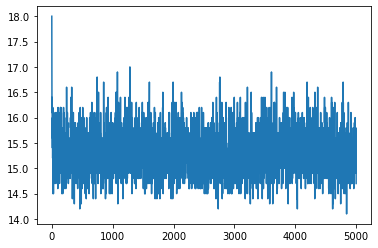

In [50]:
fig, ax = plt.subplots()
_ = ax.plot(mean_scores)

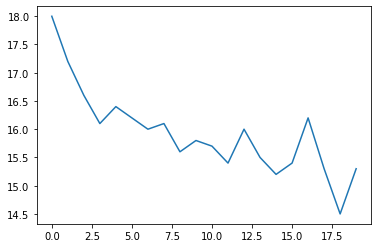

In [51]:
fig, ax = plt.subplots()
_ = ax.plot(mean_scores[:20])

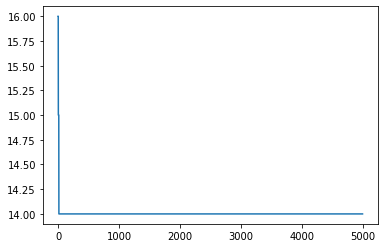

In [52]:
fig, ax = plt.subplots()
_ = ax.plot(min_scores)

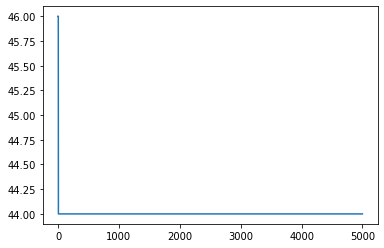

In [53]:
fig, ax = plt.subplots()
_ = ax.plot(min_ranking_distances)

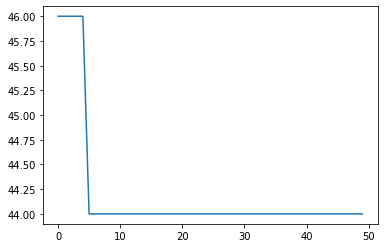

In [58]:
fig, ax = plt.subplots()
_ = ax.plot(min_ranking_distances[:50])

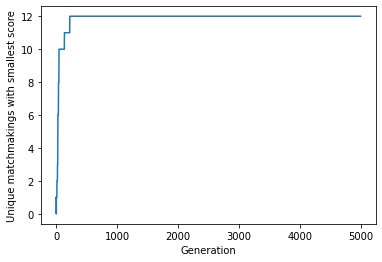

In [54]:
fig, ax = plt.subplots()
_ = ax.plot(best_matchmakings_length)

_ = ax.set_xlabel('Generation')
_ = ax.set_ylabel('Unique matchmakings with smallest score')

In [59]:
print(f'Min already played score: {min_score}')
print(f'Min ranking distance: {min_ranking_distance}')

Min already played score: 14
Min ranking distance: 44


In [60]:
selected_mm = random.choice(best_matchmakings)

In [61]:
print(selected_mm)

[[0 1 1 0 1 0 0 0 1]
 [0 0 1 1 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0]]


In [62]:
new_matches = matchmaking_matrix_to_matches(input_info['ranking'], selected_mm)

In [63]:
for m in new_matches:
    print(f'{m[0]};{m[1]}')

6;14
6;1
6;10
6;5
14;1
14;2
14;8
1;2
1;4
2;10
2;11
10;11
10;8
11;4
11;5
8;4
8;5
4;5
